In [1]:
import pandas as pd
import numpy as np

In [2]:
try:
    import folium
except:
    !pip install folium

### (!) Action Required - Upload the data

- Activate the empty cell below (cursor should blink in the empty cell below).
- Click the data symbol on the right
- Find your data set > Insert to code > Insert pandas DataFrame

Make sure to upload & import **madrid_train.csv** and **madrid_test.csv**.

For importing **madrid_test.csv**, you can create a new cell by going to `Insert` > `Insert Cell Below`
    
![as](https://i.imgur.com/mafVWHP.png)


In [15]:

import sys
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
client_01fa29576c1949bf8bf19f9e93a1ba4a = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='Qs9PoLnSj-Gpi1Hl0gOZgUpXJxYw_B08xw2wcwi_JGYu',
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_01fa29576c1949bf8bf19f9e93a1ba4a.get_object(Bucket='madridproject-donotdelete-pr-wk9vog6mroiwb0',Key='madrid_train.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_10 = pd.read_csv(body)
df_data_10.head()



,ad_id,price,region_level2_id,lat,lng,create_date,property,property_state,district_id,mts2,...,sauna,piscina-comunitaria,puerta-blindada,terraza,lavadora,serv-porteria,zona-infantil,cocina-office,parking-comunitario,distance_to_centre
0,141537319.0,550000.0,28.0,40.4040,-3.69258,22/02/2017 13:15:54,Flat,VeryGood,671.0,178.0,...,0,0,0,1,0,1,0,0,0,1.707948
1,141129777.0,84999.0,28.0,40.4212,-3.61754,17/01/2017 19:37:03,Flat,NaN,676.0,60.0,...,0,0,0,0,0,0,0,0,0,7.292788
2,141321296.0,159999.0,28.0,40.4226,-3.64750,02/02/2017 18:53:29,Flat,NaN,685.0,67.0,...,0,0,0,0,0,0,0,0,0,4.782115
3,142917234.0,515000.0,28.0,40.4429,-3.71124,15/06/2017 7:43:11,Flat,Good,177.0,139.0,...,0,0,0,0,0,0,0,0,0,2.963425
4,141506865.0,115000.0,28.0,40.3796,-3.73910,20/02/2017 13:00:42,Flat,NaN,171.0,56.0,...,0,0,1,0,0,0,0,0,0,5.131716


In [16]:

body = client_01fa29576c1949bf8bf19f9e93a1ba4a.get_object(Bucket='madridproject-donotdelete-pr-wk9vog6mroiwb0',Key='madrid_test.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_12 = pd.read_csv(body)
df_data_12.head()



,ad_id,price,region_level2_id,lat,lng,create_date,property,property_state,district_id,mts2,...,sauna,piscina-comunitaria,puerta-blindada,terraza,lavadora,serv-porteria,zona-infantil,cocina-office,parking-comunitario,distance_to_centre
0,142876815.0,158000.0,28.0,40.4092,-3.70259,13/06/2017 13:21:28,Flat,NaN,672.0,38.0,...,0,0,0,0,0,0,0,0,0,0.861961
1,141085556.0,950000.0,28.0,40.4581,-3.66027,13/01/2017 5:23:53,Flat,NaN,685.0,260.0,...,0,0,0,0,0,0,0,0,0,5.861682
2,142360318.0,135000.0,28.0,40.3985,-3.63217,03/05/2017 19:21:50,Flat,NaN,191.0,75.0,...,0,0,1,0,0,0,0,0,0,6.377449
3,142743823.0,470000.0,28.0,40.4353,-3.62496,02/06/2017 12:44:29,Flat,VeryGood,676.0,204.0,...,0,1,1,1,0,1,0,1,1,6.955439
4,142859803.0,990000.0,28.0,40.4784,-3.72466,12/06/2017 17:34:51,Flat,NaN,187.0,388.0,...,0,0,0,0,0,0,0,1,0,7.069304


### (!) Action Required - Rename the DataFrame below to the fresly imported df_data_NN

Most likely DSX have imported the data as `df_data_5`, `df_data_6` or similar. It is good practive to rename the data in the next cell, and continue from there.

* Store the `df_data_X` (where X is a number), from **madrid_train.csv** in `madrid_train`.
* Store the `df_data_X` (where X is a number), from **madrid_test.csv** in `madrid_test`.

In [18]:
madrid_train = df_data_10
madrid_test = df_data_12

## Madrid Train to train your model


## The power of DSX - Use any Open-source package to get the job done...
### like Folium - We installed it at the top of the notebook.

Folium (Leaflet) is a very nice geo data vizualisation tool - Use the !pip install [package] code to install

https://folium.readthedocs.io/en/latest/

https://github.com/python-visualization/folium


Using folium, and the coordinates for Cybele Palace as an indicator for the centre of Madrid, lets look at the density of houses for sale on a map.

In less than 10 lines of code, we have in interactive heatmap, showing the popular places where houses are for sale.

In [20]:
import folium

cybele_palace = (40.418906, -3.692084)

lat_lng_list = list( zip( list(madrid_train.lat), list(madrid_train.lng) ) )
house_density = [ (lat,lng,0.3) for (lat,lng) in lat_lng_list ]
centre_madrid = cybele_palace

from folium.plugins import HeatMap

map_with_houses = folium.Map(centre_madrid, tiles='stamentoner', zoom_start=11)

HeatMap(house_density).add_to(map_with_houses)
map_with_houses

We can see a heat map of where the houses are for sale.

Now lets start applying a little bit of maths on our data to see what we can discover.

## A Classic Linear Regression on the size of property to predict the price

http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

Linear Models, as traditional and classic as there are, are still being used. 
In fact, most banking algorithms are still using them 20 years after they first started doing 'clever stuff'.

Db2 Warehouse on Cloud (aka DashDB) is able to run them within the engine with optimized code. 
This can be very fast, but as we progess to more complex models and data manipulations, we need notebooks to have full flexibility.

In the cell below, we use sklearn to build and fit a lineair mode. The DB2 optimezed code is not used in this cell.

In [7]:
# Build a two data frames. square metre on X, and price on y axis
import numpy as np
from sklearn import datasets, linear_model

x = madrid_houses["mts2"].to_frame()
y = madrid_houses["price"].to_frame()

In [9]:
# Build a two data frames. square metre on X, and price on y axis
import numpy as np
from sklearn import datasets, linear_model

x = madrid_houses["mts2"].to_frame()
y = madrid_houses["price"].to_frame()

Now use matplotlib and linear regression to plot X and Y data.
The chart will show a shatter plot of prices and square metre together with a line showing the regression prediction. 
You will see we have quite a few 'outliers' that are either huge properties or are very expensive.
We look for outliers either to spot data quality issues, or to spot opportunity!

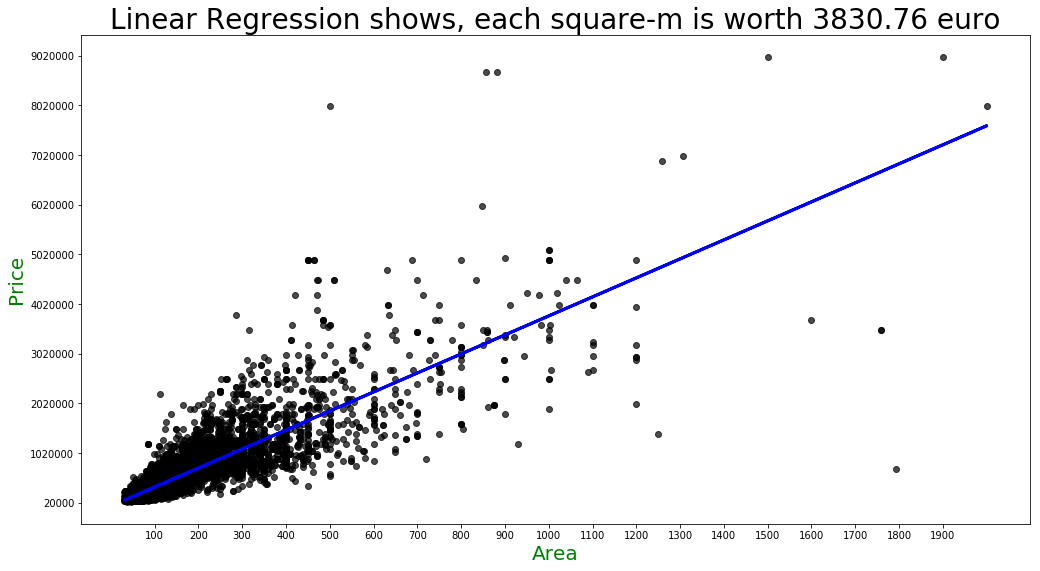

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline  

regr = linear_model.LinearRegression()
regr.fit(x, y)

# plot it as in the example at http://scikit-learn.org/
plt.figure(figsize=(17, 9))
title = "Linear Regression shows, each square-m is worth {0:.2f} euro".format( regr.coef_.flatten()[0] )
plt.title(title, fontsize=28) 
plt.scatter(madrid_houses.mts2, madrid_houses.price,  color='black', alpha=0.7)
plt.xticks((np.arange(100,2000,100)))
plt.yticks((np.arange(20000,10000000,1000000)))
plt.xlabel('Area', fontsize=20, color='green')
plt.ylabel('Price', fontsize=20, color='green')
plt.plot(x, regr.predict(x), color='blue', linewidth=3)

plt.show()

You can see that the majority of properties available are less than 400 square metre. 

A Trained/Fitted model, contains information like the Coefficients of the model.

Now lets use the linear regression to predict a house price by putting in regr.predict(100.0) 

In [12]:
print( "Intercept: ", regr.intercept_)
print( "Cooef: ", regr.coef_)
print( "")
print("A house of 100 square m, in Madrid, according to the model will cost about:" ,regr.predict(100.0))

Intercept:  [-50904.75178139]
Cooef:  [[ 3830.76252049]]

A house of 100 square m, in Madrid, according to the model will cost about: [[ 332171.50026786]]


As we saw above the coeffient was 3959.6 which is tellign us that the expected price per square metre is 3959.6 Euros.

Thats quite a lot on money, so we had better negotiate our relocation fee well.

### With so many properties available in our recommended area, we need to look at other factors !


### What is the model Performance? How well are we able to predict the price of a property in Madrid ?

### I think a House is well predicted, if the predicted price is less than 5% off from the true price

When working for a Data Project, It is good to use metrics the line of business will understand. 

We can quote lots of mathematics, but fundamentally people want to know how accurate our predictions are going to be. We do this by identifying error rates. The Mean-Squared-Error is a metrics, only a few on the planet have a feeling for.

Lets define a function to derive an error rate based on input values
Then test it based on manually passed values

In [13]:
preds = regr.predict(x)



In [ ]:

body = client_01fa29576c1949bf8bf19f9e93a1ba4a.get_object(Bucket='madridproject-donotdelete-pr-wk9vog6mroiwb0',Key='madrid_test.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_11 = pd.read_csv(body)
test = df_data_11


In [ ]:
prediction_test = regr.predict(test.mts2.to_frame() )
test["prediction"] = prediction_test

test.head()

In [ ]:
type(test) == pd.core.frame.DataFrame

In [ ]:
"prediction" in test.columns

In [ ]:
def percentage_quite_well_predicted( dataframe_with_predictions ):
    """
        How much houses can we predict well? 
        
        Input: Data frame, with a "price" column, and a "prediction" column.
        
        Output: Proportion of houses that are predicted with a MAXIMUM_RELATIVE_ERROR.
        
        E.g, a output of 0.2, tells us 20% is well predicted.
        E.g, a output of 0.99, tells us 99% is well predicted.
    """
    MAXIMUM_RELATIVE_ERROR = 0.1
    
    assert type(dataframe_with_predictions) == pd.core.frame.DataFrame, "Please provide a DataFrame as argument..."
    assert "prediction" in dataframe_with_predictions.columns, "Make sure your predictions are in the 'prediction' column..."
    assert "price" in dataframe_with_predictions.columns, "Make sure your the true price is in the 'price' column..."
    
    proportion_well_predicted = np.mean( ( np.abs(test.prediction - test.price) ) / test.price < MAXIMUM_RELATIVE_ERROR )
    return( proportion_well_predicted )

percentage_quite_well_predicted( test )

Using the manually input values, we got a value of 80%

Lets try and estimate the error rate for our housing data. 
We are calling the routine created above with the prices.

In [ ]:
prediction_test = regr.predict(test.mts2.to_frame() )
test["prediction"] = prediction_test

"With a linear model- we are able to predict {0:.2f}% of the houses well!".format( percentage_quite_well_predicted(test)*100 )

As you can see, a modest regression on square-m, will predict with an error rate of 7%.

That is, with only the square-m we are able to predict 7% of the houses.

In [ ]:
madrid_one_hot_encoded = madrid_with_metro

for col in COLUMNS_TO_INDEX_AS_CATEGORIES:
    if col in madrid_one_hot_encoded.columns:
        temp_res = pd.get_dummies(  madrid_one_hot_encoded[ col ], prefix=col )
        madrid_one_hot_encoded[ temp_res.columns ] = temp_res
        madrid_one_hot_encoded = madrid_one_hot_encoded.drop(col, 1)

madrid_one_hot_encoded.head()

In [ ]:
# We now have a wider data set !
for col in madrid_one_hot_encoded.columns[1:]:
    print( col, end=", ")

We are not interested in all columns, so just take first 40 columns and rooms, bathrooms and mts2

In [ ]:
FEATURE_FOR_MODEL = list(madrid_one_hot_encoded.columns[40:]) + ["rooms", "bathrooms","mts2"]

for feature in FEATURE_FOR_MODEL:
    print(feature, end=", ")

### Feature Engineering is just as important (or more), as creating a good model

### Optionally, change the CODE below to select features for the model to use - Normally, you would select all protential features

If you would like to use all district features, like

**district_Arganzuela, district_Barajas, district_Carabanchel, district_Centro, district_Chamartín, district_Chamberí, district_Ciudad Lineal, district_Fuencarral, district_Hortaleza, district_Latina, district_Moncloa, district_Moratalaz, district_Puente de Vallecas, district_Retiro, district_Salamanca, district_San Blas, district_Tetuán, district_Usera, district_Vicálvaro, district_Villa de Vallecas, district_Villaverde**

simply enter **`district`**, and the code will add all features containing the work district. Similar for property state

In [ ]:
"""
   Edit the line below to change the features used by the model.
   
   FEATURE_SELECTION = FEATURE_FOR_MODEL will use ALL features
   
"""
SELECTED_BY_USED_FEATURES = ["distance_to_centre", "property_state", "district", "mts2", "sauna"]

FEATURE_SELECTION = []

for feature in SELECTED_BY_USED_FEATURES:
    for potential_feature in FEATURE_FOR_MODEL:
        if feature in potential_feature:
            FEATURE_SELECTION.append(potential_feature)
            
for feat in FEATURE_SELECTION:
    print(feat, end=", ")
            

## Test / Train set creation

As a data scientist, if there is anough data, I will split my data into Training, Validation and Testing sets in order to tune my model.
Tuning (by adding features such as metro), and by configuring the algorithms to go into more levels of depth. 

In this example we are doing a two way split using 80:20

## Tweak Model parameters to get an even better performance

## Can it be good to tweak number of trees, or tree complexity ?

![](http://www.iis.ee.ic.ac.uk/icvl/iccv09_tutorial_files/random_forest_new2.png)

http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

Having split the data, this next step uses RandomForestRegressor to make predictions. The random forest regressor will only ever predict values within the range of observations or closer to zero. 
We will run this against the training set, looking at price.

In [ ]:
FEATURE_SELECTION = ["distance_to_centre", "mts2"]

In [ ]:
from sklearn.ensemble import RandomForestRegressor

"""
    Change the code below, to make the model perform better, and use all information from data as best as possible
"""
clf = RandomForestRegressor(max_depth=25, n_estimators=5)

target_t = train[ "price" ]
features_t = train[ FEATURE_SELECTION ]

clf.fit(  features_t, target_t )

features_t.head()

### The following cell attempts to identify features which influence the property price

In [ ]:
feature_imp_dict = {}
importance_list = []
for (imp, label) in list( zip( list(clf.feature_importances_), FEATURE_SELECTION ) ):
    feature_imp_dict[label] = imp
    importance_list.append(imp)

treshold = sorted(importance_list)[-2] 
important_features = {}

for key in feature_imp_dict:
    if feature_imp_dict[key] >= treshold:
        important_features[key] = feature_imp_dict[key]
        
for k,v in sorted(important_features.items(), key=lambda x:-x[1]):
    print(k, v)


### Here we see that the sq.metre is the largest indicator of price, with distance to city centre.

Now lets plot this importance of these features....

In [ ]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

dictionary = plt.figure()
dictionary.set_size_inches(35, 10.5)

D = important_features

keys = [ s[:20] for s in D.keys()]

plt.bar(range(len(D)), D.values(), align='center')
plt.xticks(fontsize=14)  
plt.xticks(range(len(D)), keys)

So based on our training set **mts2** (metre.sq), **distance_to_centre** are important features.

## Test model performance on Test set (unseen during model training)

In [ ]:
preds = clf.predict(test[ FEATURE_SELECTION ])

test["prediction"] = preds


print("{0:.2f}% is well predicted".format(100 * percentage_quite_well_predicted(test)))

By using more colorful features, and a more advanced more, we boosted our performance from around 7, to 20%